### Programita de prueba para visualizar redes dinámicas

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import ffmpeg

plt.rcParams['text.usetex'] = True

In [2]:
class model:
    def __init__(self, n_agents, w_min=1e-17, w_0=None, 
                 G=None, additive=False, theta=0, save_every=np.inf,
                 upd_w_every=np.inf, upd_graph_every=np.inf):
        self.N = n_agents
        self.w_min = w_min
        self.G = G
        self.additive = additive
        if self.G is not None:
            self.posi = {i: self.G.nodes[i]['pos'] for i in range(self.N)}
            self.theta = theta
        self.update_graph = upd_graph_every
        self.update_w = upd_w_every
        self.every = save_every
        # Initialize n agents with random risks and wealth between (0, 1] 
        # and normalize wealth
        # n[i, 0] is the wealth and n[i, 1] is the risk of agent i
        self.n = np.random.rand(self.N, 2)
        if w_0 is not None:
            self.n[:, 0] = w_0
        else:
            self.n[:, 0] = self.n[:, 0]/(np.sum(self.n[:, 0]))
        self.gini = [self.get_gini()]
        self.n_active = [self.get_actives()]

    def get_opponents(self):
        if self.G is None:
            random_array = np.random.randint(0, self.N, self.N)
            indices = np.arange(0, self.N)
            # Create array of random numbers that are not equal to the index
            # If i=j then assign j'=i+1 (j'=0 if i=N-1)
            random_array = np.where(random_array == indices, 
                                    (random_array + 1) % self.N, 
                                    random_array)
        else: 
            random_array = np.full(self.N, fill_value=-1)
            for i in range(self.N):
                neighbors = [neigh for neigh in nx.all_neighbors(self.G, i)]
                if neighbors:
                    random_array[i] = np.random.choice(neighbors)

        return random_array
    
    def is_valid(self, i, j):
        # Check if both agents have w > w_min
        return (self.n[i, 0] > self.w_min) and (self.n[j, 0] > self.w_min)

    def get_dw(self, i, j):
        return np.minimum(self.n[i, 0] * self.n[i, 1], 
                          self.n[j, 0] * self.n[j, 1])

    def get_gini(self):
        w = np.sort(self.n[:, 0])
        p_cumsum = np.cumsum(w) / np.sum(w)
        B = np.sum(p_cumsum) / self.N
        return 1 + 1/self.N - 2*B
    
    def get_actives(self):
        return np.sum(self.n[:, 0] > self.w_min)
    
    def get_liquidity():
        return

    def update_wealth(self, i, j, dw):
        self.n[i, 0] += dw
        self.n[j, 0] -= dw

    def choose_winner(self, i, j):
        raise Exception('You need to choose a valid model.')

    def MCS(self, steps):
        """
        Main MC loop
        """
        for mcs in range(steps):

            j = self.get_opponents()
            
            for i, ji in enumerate(j):
                # Check both agents have w > w_min and node is not isolated
                if self.is_valid(i, ji) and ji != -1:
                    dw = self.get_dw(i, ji)
                    winner = self.choose_winner(i, ji)
                    dw = np.where(winner == i, dw, -dw)
                    self.update_wealth(i, ji, dw)
            
            # After self.update_graph MCS change graph
            if mcs % self.update_w == 0:
                w = dict(enumerate(self.n[:, 0]))
                a = np.array(list(w.values()))
                nx.set_node_attributes(self.G, w, 'weight')
                
                ## Esto se tiene que borrar y escribir mejor
                figpath = os.path.join(os.getcwd(), 'data', "3_dynamic_gtg", "figs", "temp")
                fig = plt.figure(figsize=(4, 3), dpi=150)
                filename = os.path.join(figpath, 'test_{:05d}.png'.format(mcs))
                ax = plt.gca()
                ax.set_xlim([-.03, 1.03])
                ax.set_ylim([-.03, 1.03])
                ax.set_title('t = {}'.format(mcs))
                nx.draw(self.G, node_size=25*self.N*a, width=.2, pos=self.posi, ax=ax)
                plt.savefig(filename, format="PNG")
                plt.clf()
                plt.close(fig)
                ##
                
                ## Modificar esto después
            if (mcs + 1) % self.update_graph == 0:
                self.G = nx.geographical_threshold_graph(self.N, 
                                                         theta=self.theta, 
                                                         weight=w, dim=2, 
                                                         pos=self.posi, 
                                                         additive=self.additive)
            # After self.every MCS append new Gini index
            if (mcs + 1) % self.every == 0:
                self.gini.append(self.get_gini())
                self.n_active.append(self.get_actives())

In [3]:
a=np.random.rand(10)

In [4]:
class YSmodel(model):
    def __init__(self, n_agents, w_min=1e-17, w_0=None, 
                 G=None, additive=False, theta=0, save_every=np.inf, 
                 upd_w_every=np.inf, upd_graph_every=np.inf, f=0):
        
        super().__init__(n_agents, w_min, w_0, G, additive, theta, 
                         save_every, upd_w_every, upd_graph_every)
        # f is the social protection factor
        self.f = f
    
    def choose_winner(self, i, j):
        p = .5 + self.f*((self.n[j, 0] - self.n[i, 0]) /
                         (self.n[i, 0] + self.n[j, 0]))
        winner = np.random.choice([i, j], p=[p, 1-p])
        return winner

In [5]:
def delete_images(figpath):
    for file in os.listdir(figpath):
        print(file)
        if file.endswith('.png'):
            os.remove(os.path.join(figpath, file)) 

### Parámetros comunes del sistema y la red

In [5]:
moviepath = os.path.join(os.getcwd(), 'data', "3_dynamic_gtg", "movies")
figpath = os.path.join(os.getcwd(), 'data', "3_dynamic_gtg", "figs", "temp")
datapath = os.path.join(os.getcwd(), 'data', "3_dynamic_gtg", "data")

# Numero de nodos = Numero de agentes
n = 200
# Pesos de los nodos = riquezas iniciales de los agentes
a_0 = np.random.rand(n)
a_0 /= np.sum(a_0)
w_0 = dict(enumerate(a_0))

f_set = [0, .05, .2, .5]

MCS = 10000

upd_w = int(MCS/1000) if MCS > 1000 else 5
upd_g = 500

## Red aditiva

Conectividad: 4.71


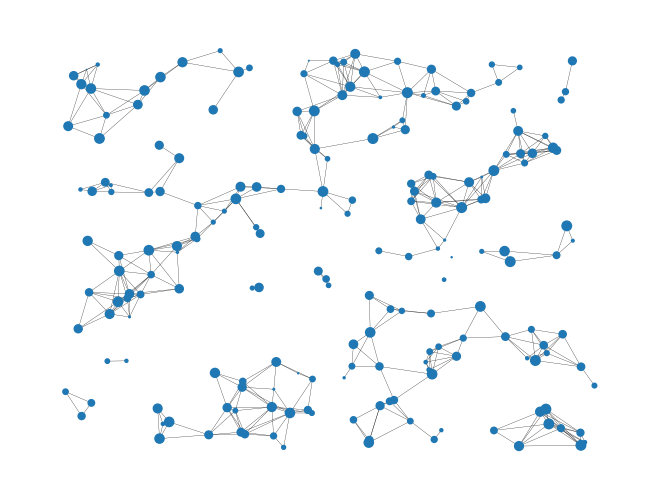

In [6]:
# Red aditiva
theta_add = 500/(2*n)

GTG_add = nx.geographical_threshold_graph(n, theta=theta_add, weight=w_0, 
                                          dim=2, additive=True)

posi = {i: GTG_add.nodes[i]['pos'] for i in range(n)}

print("Conectividad: {:.2f}".format(np.mean(list(dict(nx.degree(GTG_add)).values()))))

nx.draw(GTG_add, node_size=25*n*a_0, width=.2, pos=posi)

#### Red aditiva fija

In [8]:
for f in f_set:
    model = YSmodel(n, w_min=1e-17, w_0 = a_0, G=GTG_add, additive=True, theta=theta_add, 
                    save_every=np.inf, upd_w_every=upd_w, upd_graph_every=np.inf, f=f)
    model.MCS(MCS)
                
    # Make movie
    (
        ffmpeg
        .input(os.path.join(figpath, 'test_*.png'), pattern_type='glob', framerate=30)
        .output(os.path.join(moviepath, 'f={:.2f}_add_fix.mp4'.format(f)))
        .overwrite_output()
        .run(quiet=True)
    )

    np.save(os.path.join(datapath, 'w_f={:.2f}_add_fix').format(f), model.n[:, 0])

    delete_images(figpath)

test_09500.png
test_06030.png
test_03070.png
test_03290.png
test_07400.png
test_04410.png
test_01780.png
test_03030.png
test_01910.png
test_06400.png
test_00890.png
test_05840.png
test_09730.png
test_08550.png
test_01570.png
test_05030.png
test_03390.png
test_05380.png
test_00650.png
test_05540.png
test_05910.png
test_00960.png
test_06130.png
test_01630.png
test_06270.png
test_05140.png
test_00210.png
test_04110.png
test_00680.png
test_03590.png
test_00500.png
test_01940.png
test_03850.png
test_06630.png
test_01830.png
test_03810.png
test_04980.png
test_09510.png
test_06650.png
test_03620.png
test_05130.png
test_07020.png
test_04990.png
test_03500.png
test_02080.png
test_05800.png
test_05270.png
test_04080.png
test_03200.png
test_09110.png
test_06800.png
test_00440.png
test_09340.png
test_03680.png
test_06390.png
test_04220.png
test_07970.png
test_05110.png
test_04720.png
test_00310.png
test_08790.png
test_03770.png
test_00280.png
test_08420.png
test_08230.png
test_07650.png
test_00780

#### Red aditiva 'dinámica'

In [9]:
for f in f_set:
    model = YSmodel(n, w_min=1e-17, w_0 = a_0, G=GTG_add, additive=True, theta=theta_add, 
                    save_every=np.inf, upd_w_every=upd_w, upd_graph_every=upd_g, f=f)
    model.MCS(MCS)
                
    # Make movie
    (
        ffmpeg
        .input(os.path.join(figpath, 'test_*.png'), pattern_type='glob', framerate=30)
        .output(os.path.join(moviepath, 'f={:.2f}_add_din.mp4'.format(f)))
        .overwrite_output()
        .run(quiet=True)
    )

    np.save(os.path.join(datapath, 'w_f={:.2f}_add_din').format(f), model.n[:, 0])

    delete_images(figpath)

test_09500.png
test_06030.png
test_03070.png
test_03290.png
test_07400.png
test_04410.png
test_01780.png
test_03030.png
test_01910.png
test_06400.png
test_00890.png
test_05840.png
test_09730.png
test_08550.png
test_01570.png
test_05030.png
test_03390.png
test_05380.png
test_00650.png
test_05540.png
test_05910.png
test_00960.png
test_06130.png
test_01630.png
test_06270.png
test_05140.png
test_00210.png
test_04110.png
test_00680.png
test_03590.png
test_00500.png
test_01940.png
test_03850.png
test_06630.png
test_01830.png
test_03810.png
test_04980.png
test_09510.png
test_06650.png
test_03620.png
test_05130.png
test_07020.png
test_04990.png
test_03500.png
test_02080.png
test_05800.png
test_05270.png
test_04080.png
test_03200.png
test_09110.png
test_06800.png
test_00440.png
test_09340.png
test_03680.png
test_06390.png
test_04220.png
test_07970.png
test_05110.png
test_04720.png
test_00310.png
test_08790.png
test_03770.png
test_00280.png
test_08420.png
test_08230.png
test_07650.png
test_00780

## Red multiplicativa

Conectividad: 4.67


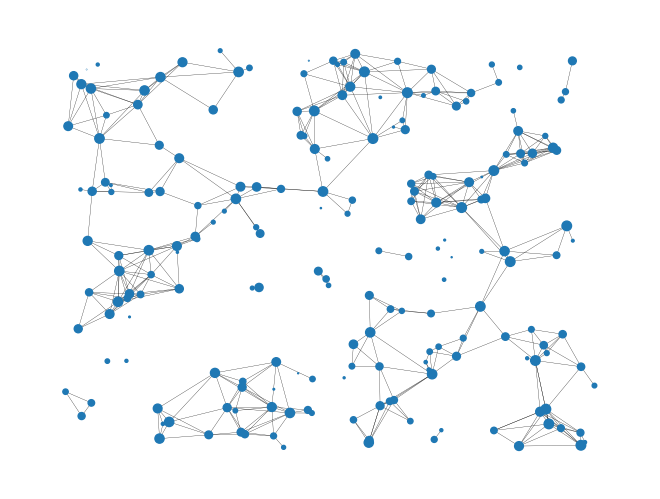

In [7]:
theta_mul = 250/(2*n**2)

# Red multiplicativa
GTG_mul = nx.geographical_threshold_graph(n, theta=theta_mul, weight=w_0, 
                                          dim=2, pos=posi, additive=False)

print("Conectividad: {:.2f}".format(np.mean(list(dict(nx.degree(GTG_mul)).values()))))

nx.draw(GTG_mul, node_size=25*n*a_0, width=.2, pos=posi)


#### Red multiplicativa fija

In [10]:
for f in f_set:
    model = YSmodel(n, w_min=1e-17, w_0 = a_0, G=GTG_add, additive=False, theta=theta_mul, 
                    save_every=np.inf, upd_w_every=upd_w, upd_graph_every=np.inf, f=f)
    model.MCS(MCS)
                
    # Make movie
    (
        ffmpeg
        .input(os.path.join(figpath, 'test_*.png'), pattern_type='glob', framerate=30)
        .output(os.path.join(moviepath, 'f={:.2f}_mul_fix.mp4'.format(f)))
        .overwrite_output()
        .run(quiet=True)
    )

    np.save(os.path.join(datapath, 'w_f={:.2f}_mul_fix').format(f), model.n[:, 0])

    delete_images(figpath)

test_09500.png
test_06030.png
test_03070.png
test_03290.png
test_07400.png
test_04410.png
test_01780.png
test_03030.png
test_01910.png
test_06400.png
test_00890.png
test_05840.png
test_09730.png
test_08550.png
test_01570.png
test_05030.png
test_03390.png
test_05380.png
test_00650.png
test_05540.png
test_05910.png
test_00960.png
test_06130.png
test_01630.png
test_06270.png
test_05140.png
test_00210.png
test_04110.png
test_00680.png
test_03590.png
test_00500.png
test_01940.png
test_03850.png
test_06630.png
test_01830.png
test_03810.png
test_04980.png
test_09510.png
test_06650.png
test_03620.png
test_05130.png
test_07020.png
test_04990.png
test_03500.png
test_02080.png
test_05800.png
test_05270.png
test_04080.png
test_03200.png
test_09110.png
test_06800.png
test_00440.png
test_09340.png
test_03680.png
test_06390.png
test_04220.png
test_07970.png
test_05110.png
test_04720.png
test_00310.png
test_08790.png
test_03770.png
test_00280.png
test_08420.png
test_08230.png
test_07650.png
test_00780

#### Red multiplicativa 'dinámica'

In [11]:
for f in f_set:
    model = YSmodel(n, w_min=1e-17, w_0 = a_0, G=GTG_add, additive=False, theta=theta_mul, 
                    save_every=np.inf, upd_w_every=upd_w, upd_graph_every=upd_g, f=f)
    model.MCS(MCS)
                
    # Make movie
    (
        ffmpeg
        .input(os.path.join(figpath, 'test_*.png'), pattern_type='glob', framerate=30)
        .output(os.path.join(moviepath, 'f={:.2f}_mul_din.mp4'.format(f)))
        .overwrite_output()
        .run(quiet=True)
    )

    np.save(os.path.join(datapath, 'w_f={:.2f}_mul_din').format(f), model.n[:, 0])

    delete_images(figpath)

test_09500.png
test_06030.png
test_03070.png
test_03290.png
test_07400.png
test_04410.png
test_01780.png
test_03030.png
test_01910.png
test_06400.png
test_00890.png
test_05840.png
test_09730.png
test_08550.png
test_01570.png
test_05030.png
test_03390.png
test_05380.png
test_00650.png
test_05540.png
test_05910.png
test_00960.png
test_06130.png
test_01630.png
test_06270.png
test_05140.png
test_00210.png
test_04110.png
test_00680.png
test_03590.png
test_00500.png
test_01940.png
test_03850.png
test_06630.png
test_01830.png
test_03810.png
test_04980.png
test_09510.png
test_06650.png
test_03620.png
test_05130.png
test_07020.png
test_04990.png
test_03500.png
test_02080.png
test_05800.png
test_05270.png
test_04080.png
test_03200.png
test_09110.png
test_06800.png
test_00440.png
test_09340.png
test_03680.png
test_06390.png
test_04220.png
test_07970.png
test_05110.png
test_04720.png
test_00310.png
test_08790.png
test_03770.png
test_00280.png
test_08420.png
test_08230.png
test_07650.png
test_00780